In [10]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
from scipy.signal import welch
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

In [11]:
M_points_signal = 1024

N_number_signals = 1000
Time = 3
fs = M_points_signal/Time

vector_time = np.linspace(0, Time, M_points_signal)

In [21]:
def generate_signal():
    freq1 = 1
    freq2 = 3
    freq3 = 5
    
    omega_0 = 2*np.pi
    
    amplitude1 = 1
    amplitude2 = 1/3
    amplitude3 = 1/5
    
    #signal =(amplitude1*np.cos(omega_0*freq1*vector_time) - amplitude2*np.cos(omega_0*freq2*vector_time) + amplitude3*np.cos(omega_0*freq3*vector_time))
    signal =(amplitude1*np.cos(omega_0*freq1*vector_time) - amplitude2*np.cos(omega_0*freq2*vector_time) + amplitude3*np.cos((omega_0+np.pi/2)*freq3*vector_time))
    return signal

In [22]:
def noise_gaussian(mean, level_noise,sizes):
    noise = np.random.normal(mean, level_noise, size= M_points_signal)
    return noise

In [23]:
def calculate_average_psd(signal, fs):
    f, psd = welch(signal, fs=fs)
    average_psd = np.mean(psd, axis=0)
    return f, average_psd

In [24]:
def psd_generate(signal,fs, nperseg):
    fq, Pxx_den = welch(signal, fs=fs, nperseg=nperseg)
    return fq, Pxx_den

In [28]:
sg = generate_signal()
sg1 =generate_signal() + noise_gaussian(0, 0.1, M_points_signal)
sg2 = generate_signal() + noise_gaussian(0, 0.3, M_points_signal)
sg3 = generate_signal() + noise_gaussian(0, 0.5, M_points_signal)
sg4 = generate_signal() + noise_gaussian(0, 1, M_points_signal)
sg5 = generate_signal() + noise_gaussian(0, 3, M_points_signal)
sg6 = generate_signal() + noise_gaussian(0, 10, M_points_signal)
#sg7 = generate_signal() + noise_gaussian(0, 30, M_points_signal)


In [55]:
#PSD
fq, Pxx_sg = psd_generate(sg, fs, M_points_signal)
fq1, Pxx_sg1 = psd_generate(sg1, fs, M_points_signal)
fq2, Pxx_sg2 = psd_generate(sg2, fs, M_points_signal)
fq3, Pxx_sg3 = psd_generate(sg3, fs, M_points_signal)
fq4, Pxx_sg4 = psd_generate(sg4, fs, M_points_signal)
fq5, Pxx_sg5 = psd_generate(sg5, fs, M_points_signal)
fq6, Pxx_sg6 = psd_generate(sg6, fs, M_points_signal)
#fq7, Pxx_sg7 = psd_generate(sg7, fs, M_points_signal)

psds = np.array([Pxx_sg, Pxx_sg1, Pxx_sg2, Pxx_sg3, Pxx_sg4, Pxx_sg5, Pxx_sg6])
print(psds)

[[1.38605302e-06 2.13685579e-06 2.47809108e-01 ... 1.19304481e-20
  1.18512596e-20 5.91242934e-21]
 [4.49120782e-05 7.67661147e-05 2.48896741e-01 ... 1.02117804e-04
  8.56929145e-05 3.85450324e-08]
 [1.51309761e-05 1.24251840e-04 2.38083630e-01 ... 1.19606358e-04
  9.75403336e-05 1.81489078e-04]
 ...
 [2.83907614e-04 7.74609730e-03 2.77139298e-01 ... 2.78975902e-03
  6.06173101e-03 2.82929273e-03]
 [2.72856558e-03 4.44162780e-02 1.31604277e-01 ... 1.97400807e-02
  4.58594961e-02 4.23585113e-04]
 [6.76874437e-02 3.28546393e-01 1.02493728e+00 ... 5.86327452e-01
  6.60102444e-02 1.15366282e-02]]


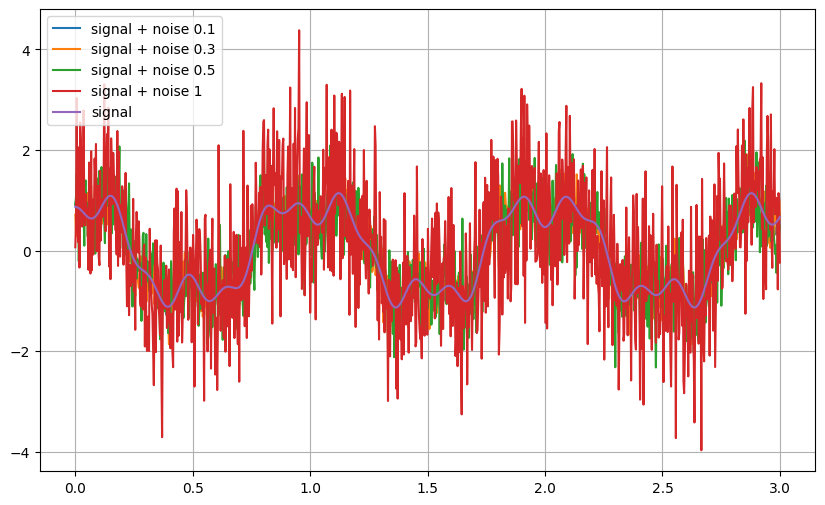

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(vector_time, sg1, label='signal + noise 0.1')
plt.plot(vector_time, sg2, label='signal + noise 0.3')
plt.plot(vector_time, sg3, label='signal + noise 0.5')
plt.plot(vector_time, sg4, label='signal + noise 1')
#plt.plot(vector_time, sg5, label='signal + noise 3')
#plt.plot(vector_time, sg6, label='signal + noise 10')
#plt.plot(vector_time, sg7, label='signal + noise 30')
plt.plot(vector_time, sg, label='signal')
plt.legend()
plt.grid(True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10488\2814671040.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-9, 0)


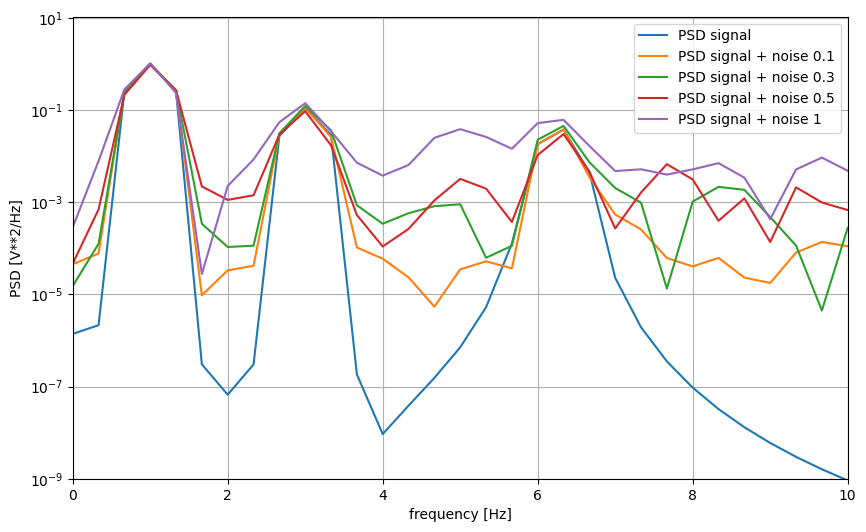

In [35]:
plt.figure(figsize=(10, 6))
plt.semilogy(fq, Pxx_sg, label='PSD signal')
plt.semilogy(fq1, Pxx_sg1, label='PSD signal + noise 0.1')
plt.semilogy(fq2, Pxx_sg2, label='PSD signal + noise 0.3')
plt.semilogy(fq3, Pxx_sg3, label='PSD signal + noise 0.5')
plt.semilogy(fq4, Pxx_sg4, label='PSD signal + noise 1')
#plt.semilogy(fq5, Pxx_sg5, label='PSD signal + noise 3')
#plt.semilogy(fq6, Pxx_sg6, label='PSD signal + noise 10')
#plt.semilogy(fq7, Pxx_sg7, label='PSD signal + noise 30')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(10**-9, 0)
plt.show()


In [40]:
def calculate_threshold(*Pxx_Dimension):
    Pxx_concatenate = np.concatenate(Pxx_Dimension)
    threshold = np. percentile(Pxx_concatenate, 95)
    return threshold


threshold = calculate_threshold(Pxx_sg, Pxx_sg1, Pxx_sg2, Pxx_sg3, Pxx_sg4, Pxx_sg5, Pxx_sg6)

def detect_first_harmonic(fq, Pxx_den, threshold):
    index_harmonic = np.where(Pxx_den > threshold)[0]
    if len (index_harmonic)> 0:
        index_first_harmonic = index_harmonic[0]
        freq_first_harmonic = fq[index_first_harmonic]
        power_first_harmonic = Pxx_den[index_first_harmonic]
        return freq_first_harmonic, power_first_harmonic
    else:
        
        return None, None
    

In [43]:
fq_harmonic_sg, power_harmonic_sg = detect_first_harmonic (fq, Pxx_sg, threshold)
fq_harmonic_sg1, power_harmonic_sg1 = detect_first_harmonic(fq1, Pxx_sg1, threshold)
fq_harmonic_sg2, power_harmonic_sg2 = detect_first_harmonic(fq2, Pxx_sg2, threshold)
fq_harmonic_sg3, power_harmonic_sg3 = detect_first_harmonic(fq3, Pxx_sg3, threshold)
fq_harmonic_sg4, power_harmonic_sg4 = detect_first_harmonic(fq4, Pxx_sg4, threshold)
fq_harmonic_sg5, power_harmonic_sg5 = detect_first_harmonic(fq5, Pxx_sg5, threshold)
fq_harmonic_sg6, power_harmonic_sg6 = detect_first_harmonic(fq6, Pxx_sg6, threshold)

print(f"Frequency first harmonic signal: {fq_harmonic_sg} Hz, power: {power_harmonic_sg}")
print(f"Frequency first harmonic signal + noise 0.1: {fq_harmonic_sg1} Hz, power: {power_harmonic_sg1}")
print(f"Frequency first harmonic signal + noise 0.3: {fq_harmonic_sg2} Hz, power: {power_harmonic_sg2}")
print(f"Frequency first harmonic signal + noise 0.5: {fq_harmonic_sg3} Hz, power: {power_harmonic_sg3}")
print(f"Frequency first harmonic signal + noise 1: {fq_harmonic_sg4} Hz, power: {power_harmonic_sg4}")
print(f"Frequency first harmonic signal + noise 3: {fq_harmonic_sg5} Hz, power: {power_harmonic_sg5}")
print(f"Frequency first harmonic signal + noise 10: {fq_harmonic_sg6} Hz, power: {power_harmonic_sg6}")



    

Frequency first harmonic signal: 1.0 Hz, power: 1.000014484300703
Frequency first harmonic signal + noise 0.1: 1.0 Hz, power: 1.0167434749250093
Frequency first harmonic signal + noise 0.3: 1.0 Hz, power: 0.9990927800060297
Frequency first harmonic signal + noise 0.5: 1.0 Hz, power: 0.9450436912668286
Frequency first harmonic signal + noise 1: 1.0 Hz, power: 1.0219816958988817
Frequency first harmonic signal + noise 3: None Hz, power: None
Frequency first harmonic signal + noise 10: 0.6666666666666666 Hz, power: 1.0249372779698211


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10488\1964858292.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-9, 0)


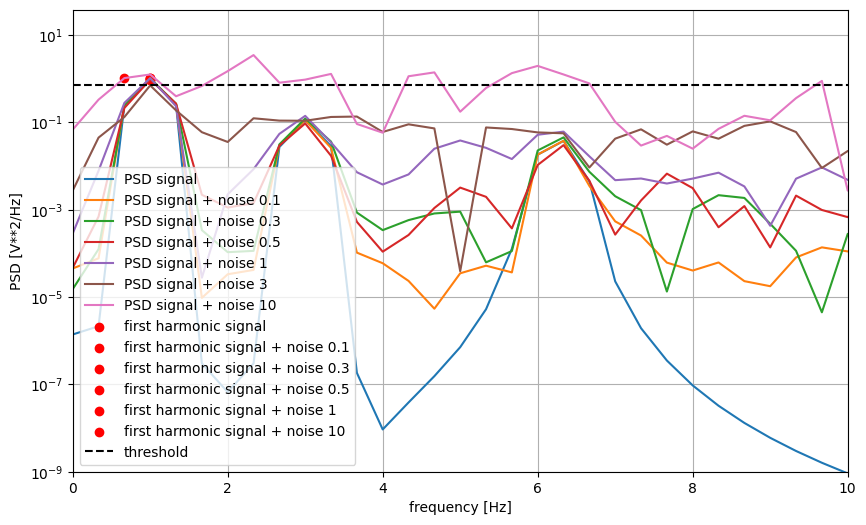

In [46]:
plt.figure(figsize=(10, 6))
plt.semilogy(fq, Pxx_sg, label='PSD signal')
plt.semilogy(fq1, Pxx_sg1, label='PSD signal + noise 0.1')
plt.semilogy(fq2, Pxx_sg2, label='PSD signal + noise 0.3')
plt.semilogy(fq3, Pxx_sg3, label='PSD signal + noise 0.5')
plt.semilogy(fq4, Pxx_sg4, label='PSD signal + noise 1')
plt.semilogy(fq5, Pxx_sg5, label='PSD signal + noise 3')
plt.semilogy(fq6, Pxx_sg6, label='PSD signal + noise 10')

if fq_harmonic_sg is not None:
    plt.scatter(fq_harmonic_sg, power_harmonic_sg, color='red', label='first harmonic signal')
if fq_harmonic_sg1 is not None:
    plt.scatter(fq_harmonic_sg1, power_harmonic_sg1, color='red', label='first harmonic signal + noise 0.1')
if fq_harmonic_sg2 is not None:
    plt.scatter(fq_harmonic_sg2, power_harmonic_sg2, color='red', label='first harmonic signal + noise 0.3')
if fq_harmonic_sg3 is not None:
    plt.scatter(fq_harmonic_sg3, power_harmonic_sg3, color='red', label='first harmonic signal + noise 0.5')
if fq_harmonic_sg4 is not None:
    plt.scatter(fq_harmonic_sg4, power_harmonic_sg4, color='red', label='first harmonic signal + noise 1')
if fq_harmonic_sg5 is not None:
    plt.scatter(fq_harmonic_sg5, power_harmonic_sg5, color='red', label='first harmonic signal + noise 3')
if fq_harmonic_sg6 is not None:
    plt.scatter(fq_harmonic_sg6, power_harmonic_sg6, color='red', label='first harmonic signal + noise 10')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.axhline(y = threshold, color='black', linestyle='--', label='threshold')
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(10**-9, 0)
plt.show()

In [50]:
def find_index_harmonic(array , value):
        return (np.abs(array - value)).argmin()

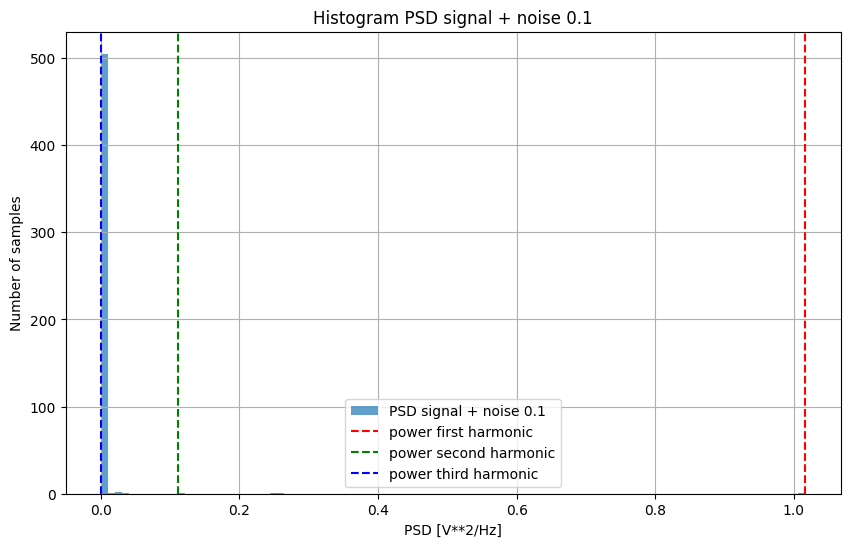

In [53]:
fq1_index = find_index_harmonic(fq1, 1)
fq2_index = find_index_harmonic(fq2, 3)
fq3_index = find_index_harmonic(fq3, 5)

harmonic1_power = Pxx_sg1[fq1_index]
harmonic2_power = Pxx_sg1[fq2_index]
harmonic3_power = Pxx_sg1[fq3_index]

plt.figure(figsize=(10, 6))
plt.hist(Pxx_sg1, bins=100, alpha=0.7, label='PSD signal + noise 0.1')
plt.title('Histogram PSD signal + noise 0.1')
plt.xlabel('PSD [V**2/Hz]')
plt.ylabel('Number of samples')
plt.axvline(x = harmonic1_power, color='red', linestyle='--', label='power first harmonic')
plt.axvline(x = harmonic2_power, color='green', linestyle='--', label='power second harmonic')
plt.axvline(x = harmonic3_power, color='blue', linestyle='--', label='power third harmonic')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
x_train, X_test, y_train, y_test = train_test_split(psds, psds, test_size=0.2, random_state=42)

model_NN_MLP = Sequential([
    Dense(128, activation='relu', input_shape=(M_points_signal,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(psds.shape[1])
])

model_NN_MLP.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_NN_MLP.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)





ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_24" is incompatible with the layer: expected axis -1 of input shape to have value 1024, but received input with shape (None, 513)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 513), dtype=float32)
  • training=True
  • mask=None

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━

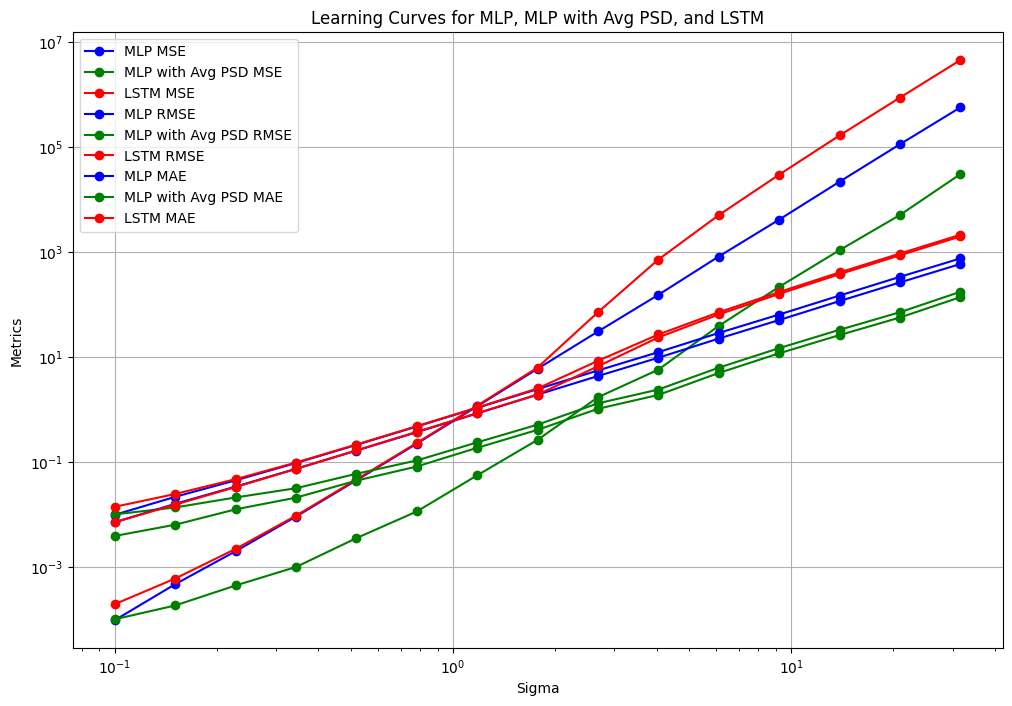

: 

In [64]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tabulate import tabulate

# Parámetros generales
num_samples = 1000
signal_length = 1024
fs = 1.0
X_t = np.sin(np.linspace(0, 2 * np.pi, signal_length))
epochs = 20
learning_rate = 0.001
test_size = 0.2
batch_size = 64
sigmas = np.logspace(-1, 1.5, 15)

# Diccionario para guardar resultados
results = {
    'Sigma': sigmas,
    'MLP MSE': [],
    'MLP RMSE': [],
    'MLP MAE': [],
    'MLP with Avg PSD MSE': [],
    'MLP with Avg PSD RMSE': [],
    'MLP with Avg PSD MAE': [],
    'LSTM MSE': [],
    'LSTM RMSE': [],
    'LSTM MAE': []
}

# Funciones de ayuda y bucle principal (ya definidos antes)
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

def train_mlp(X_train, y_train, X_test, y_test):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(X_train.shape[1])
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test, y_test), verbose=0)
    return model

def train_lstm(X_train, y_train, X_test, y_test):
    X_train_lstm = X_train[..., np.newaxis]
    X_test_lstm = X_test[..., np.newaxis]
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(32),
        Dense(X_train.shape[1])
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test_lstm, y_test), verbose=0)
    return model

for sigma in sigmas:
    noise_variance = sigma ** 2
    noise = np.random.randn(num_samples, signal_length) * np.sqrt(noise_variance)
    signals = X_t + noise

    psd_data = np.array([welch(signal, fs=fs, nperseg=256)[1] for signal in signals])
    avg_psd = np.mean(psd_data, axis=0)

    X_train, X_test, y_train, y_test = train_test_split(psd_data, psd_data, test_size=test_size, random_state=42)

    mlp_model = train_mlp(X_train, y_train, X_test, y_test)
    y_pred_mlp = mlp_model.predict(X_test)
    mse, rmse, mae = calculate_metrics(y_test, y_pred_mlp)
    results['MLP MSE'].append(mse)
    results['MLP RMSE'].append(rmse)
    results['MLP MAE'].append(mae)

    mlp_avg_model = train_mlp(X_train, np.tile(avg_psd, (X_train.shape[0], 1)),
                              X_test, np.tile(avg_psd, (X_test.shape[0], 1)))
    y_pred_mlp_avg = mlp_avg_model.predict(X_test)
    mse, rmse, mae = calculate_metrics(np.tile(avg_psd, (X_test.shape[0], 1)), y_pred_mlp_avg)
    results['MLP with Avg PSD MSE'].append(mse)
    results['MLP with Avg PSD RMSE'].append(rmse)
    results['MLP with Avg PSD MAE'].append(mae)

    lstm_model = train_lstm(X_train, y_train, X_test, y_test)
    y_pred_lstm = lstm_model.predict(X_test[..., np.newaxis])
    mse, rmse, mae = calculate_metrics(y_test, y_pred_lstm)
    results['LSTM MSE'].append(mse)
    results['LSTM RMSE'].append(rmse)
    results['LSTM MAE'].append(mae)

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Graficar resultados usando plt.semilogy() para escala logarítmica en y
metrics = ['MSE', 'RMSE', 'MAE']
models = ['MLP', 'MLP with Avg PSD', 'LSTM']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        plt.semilogy(df_results['Sigma'], df_results[f'{model} {metric}'],
                     marker='o', color=colors[j], label=f'{model} {metric}')

plt.xscale('log')
plt.xlabel('Sigma')
plt.ylabel('Metrics')
plt.title('Learning Curves for MLP, MLP with Avg PSD, and LSTM')
plt.legend()
plt.grid(True)

# Mostrar gráfica
plt.show()
